In [20]:
import math
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse.linalg as sla
from scipy.sparse import csc_array
from pymrm import construct_grad, construct_convflux_upwind, interp_cntr_to_stagg_tvd, minmod, construct_div, newton, construct_coefficient_matrix, NumJac, non_uniform_grid, update_csc_array_indices, construct_convflux_upwind, construct_interface_matrices

In [22]:
class ParticleModel:
    """
    1D diffusion-convection-reaction model with nonlinear kinetics, dynamic porosity and heat transfer.

    This class solves transient or steady-state mass and energy balances in a porous spherical particle.
    It supports arbitrary nonlinear reaction kinetics, time-dependent porosity for isothermal particle. 

    It builds the full Jacobian matrix and residual vector for implicit time integration with Newton's method.
    The model can be used for single particles or coupled to reactor-scale simulations.

    Parameters
    ----------
    shape : tuple
        Shape of the concentration field (number of grid points, number of components).
    axis : int, optional
        Axis along which diffusion and convection occur (default: 0).
    L : float, optional
        Length of the domain (default: 1.0).
    v : float or array, optional
        Velocity profile (default: 1.0).
    D : float or array, optional
        Diffusion coefficients (default: 0.0).
    c_0 : float or array, optional
        Initial concentration field (default: 0.0).
    h_mass : float, optional
        Mass transfer coefficient for outer boundary (default: 1.0).
    T : float, optional
        Temperature of the particle (default: 750.0).
    rho_bulk : array, optional
        Bulk gas density for boundary mass transfer (default: None).
    dt : float, optional
        Time step size (default: np.inf for steady-state).
    callback_newton : callable, optional
        Callback for Newton iteration (default: None).
    """

    def __init__(self, shape, axis = 0, L = 1.0, v = 1.0, D = 0.0,
                 c_0 = 0.0, h_mass=1.0, T = 750, rho_bulk=None, dt=np.inf, freq_out=10, callback_newton = None):
        # Initialize model parameters
        self.T = T 
        self.shape = shape
        self.h_mass = h_mass
        self.rho_bulk = np.zeros(self.shape[1]) if rho_bulk is None else np.asarray(rho_bulk)
        self.axis = axis
        self.v = np.asarray(v)
        self.D = np.asarray(D)
        self.L = L
        self.dt = dt
        self.freq_out = freq_out

        # Porosity model constants
        self.eps_B0 = 0.4     # Initial porosity
        self.eps_Cf = 0.91     # Final porosity
        self.rho_B0 = 1000.0   # Initial biomass density [kg/m³]
        self.rho_Cf = 1000  # Final char density [kg/m³]
        
        # Grid initialization
        self.z_f = np.linspace(0, self.L, self.shape[self.axis] + 1)
        self.z_c = 0.5 * (self.z_f[:-1] + self.z_f[1:])
        self.init_field(c_0)
        
        # Jacobian helper
        self.callback_newton = callback_newton
        self.numjac = NumJac(shape) 
    
    def init_field(self, c_0=0):
        """
        Initialize the concentration field with a uniform value.
        """
        # Concentration field
        c = np.asarray(c_0)
        shape = (1,) * (len(self.shape) - c.ndim) + c.shape
        c = c.reshape(shape)
        self.c = np.broadcast_to(c, self.shape).copy()
        self.c_old = self.c.copy()  # Store the old concentration field for time-stepping

        # Porosity field
        self.eps_p = np.ones(self.shape)
        self.eps_p_old = np.ones(self.shape)
        for j in [1, 2, 5]:
            self.eps_p[:, j] = self.eps_B0
            self.eps_p_old[:, j] = self.eps_B0

    def evaluate_kinetics(self):
        p = {
            'A1': 4.38e9,    'E1': 152.7e3,
            'A2': 1.08e10,   'E2': 147e3,
            'A3': 3.27e6,    'E3': 111.7e3,
            'A4': 4.28e6,    'E4': 107.5e3,
            'A5': 1e5,       'E5': 108e3,
            'Avap': 5.13e10, 'Evap': 88e3,
            'R': 8.314
        }
        
        R = p['R']
        return {
            'K1': p['A1'] * np.exp(-p['E1'] / (R * self.T)),
            'K2': p['A2'] * np.exp(-p['E2'] / (R * self.T)),
            'K3': p['A3'] * np.exp(-p['E3'] / (R * self.T)),
            'K4': p['A4'] * np.exp(-p['E4'] / (R * self.T)),
            'K5': p['A5'] * np.exp(-p['E5'] / (R * self.T)),
            'Kvap': p['Avap'] * np.exp(-p['Evap'] / (R * self.T)),
        }


    def update_kinetics(self, c):
        B, T_tar, G, C, M, W = [c[..., j] for j in range(6)]
        k = self.evaluate_kinetics()   # ← here is where k is evaluated at current T
    
        R = np.zeros_like(c)
    
        # Biomass
        R[..., 0] = -(k['K1'] + k['K2'] + k['K3']) * B
    
        # Tar
        R[..., 1] = k['K2'] * B - (k['K4'] + k['K5']) * self.eps_p[..., 1] * T_tar
    
        # Gas
        R[..., 2] = k['K1'] * B + k['K4'] * self.eps_p[..., 2] * T_tar
    
        # Char
        R[..., 3] = k['K3'] * B + k['K5'] * self.eps_p[..., 3] * T_tar
    
        # Moisture
        R[..., 4] = -k['Kvap'] * M
    
        # Water vapor
        R[..., 5] = k['Kvap'] * M
    
        return R
    
    def update_porosity(self):
        """
        Update porosity field based on biomass conversion for gas-phase components only.
        Solid-phase components (B, M, C) keep eps_p = 1.
        """
        rho_B = self.c[:, 0]
        rho_C = self.c[:, 3]
        XB = (self.rho_B0 - (rho_B + rho_C)) / (self.rho_B0 - self.rho_Cf + 1e-12)
        XB = np.clip(XB, 0.0, 1.0)
        eps_dynamic = self.eps_B0 * (1 - XB) + self.eps_Cf * XB
        eps_dynamic = np.clip(eps_dynamic, self.eps_B0, self.eps_Cf)
    
        self.eps_p = np.ones_like(self.c) 
    
         # Gas phase components
        for j in [1, 2, 5]:
            self.eps_p[:, j] = eps_dynamic
            
    def update_bc(self):
        Nc = self.shape[1]
        gas_idxs = [1, 2, 5, 6]            
        
        bc_L = {
            'a': [[1.0] * Nc],
            'b': [[0.0] * Nc],
            'd': [[0.0] * Nc]
        }
        
        bc_R = {
            'a': [[0.0] * Nc],
            'b': [[1.0] * Nc],
            'd': [[self.rho_bulk[i] if i==6 else 0.0 for i in range(Nc)]]
        }


        self.bc = (bc_L, bc_R)

    
    def update_jac(self):
        """
        Construct the Jacobian matrix and constant terms for the system.
        """
        
        # Effective diffusion
        D_eff_center = self.eps_p * self.D                     
        D_eff_face = 0.5 * (D_eff_center[:-1] + D_eff_center[1:])  
        D_eff_face = np.vstack([D_eff_face[0], D_eff_face, D_eff_face[-1]])  

        # Construct the Jacobian matrix and constant terms for the system
        grad_mat, grad_bc  = construct_grad(self.shape, self.z_f, self.z_c, self.bc, axis=self.axis)  # Gradient operator
        self.div_mat = construct_div(self.c.shape, self.z_f,nu=2, axis=self.axis)  # Divergence operator
        diff_mat = construct_coefficient_matrix(D_eff_face, shape=self.shape, axis=self.axis)
        convflux_mat, convflux_bc = construct_convflux_upwind(self.shape, self.z_f, self.z_c, self.bc, axis=self.axis, v = self.v)  # Convection flux operator 
        jac_convdiff = self.div_mat @ (convflux_mat -diff_mat @ grad_mat) #- div_v_mat # Diffusion term
        self.g_const = self.div_mat @ (convflux_bc -diff_mat @ grad_bc)  # Boundary condition forcing term
        jac_accum = construct_coefficient_matrix(1.0/self.dt, shape = self.shape)  # Accumulation term
        self.jac_const = jac_accum + jac_convdiff  # Total Jacobian matrix

    def g(self, c):
        """
        Compute the residual vector and Jacobian matrix for the current time step,
        with debug prints focused on detecting TVD interpolation failures.
        """
        c_new = c.reshape(self.shape)
        self.c[...] = c_new

        self.update_porosity()
        self.update_bc()
        self.update_jac()
        
        # TVD interpolation 
        c_f, dc_f = interp_cntr_to_stagg_tvd(self.c, self.z_f, self.z_c, self.bc, self.v, minmod)
    
        dg_conv = self.div_mat @ (self.v * dc_f).reshape((-1, 1))
        c_flat = c.reshape(-1, 1)
        g = self.g_const + self.jac_const @ (self.eps_p * c).reshape(-1, 1) + dg_conv - (self.eps_p_old * self.c_old).reshape(-1, 1) / self.dt

    
        # Reaction source and jacobian
        g_react, jac_react = self.numjac(self.update_kinetics, self.c)
    
        g -= g_react.reshape((-1, 1))
        jac = self.jac_const - jac_react


        return g, jac

    def step_dt(self):
        """
        Store the current concentration and porosity field as the previous values for time stepping.
        """
        self.c_old = self.c.copy()
        self.eps_p_old = self.eps_p.copy()


    def solve(self):
        """
        Solve the system using Newton's method.
        """
        result = newton(lambda c: self.g(c), self.c, maxfev=10, callback=self.callback_newton)
        self.c[...] = result.x.reshape(self.c.shape)  # Update the concentration field


Convection Error Metrics:
  L1 norm   = 2.0898e-03
  L2 norm   = 1.5409e-02
  L∞ norm   = 1.4751e-01
  RMSE      = 1.5409e-02

Diffusion Error Metrics:
  L1 norm   = 2.7014e-03
  L2 norm   = 2.9843e-02
  L∞ norm   = 4.2185e-01
  RMSE      = 2.9843e-02



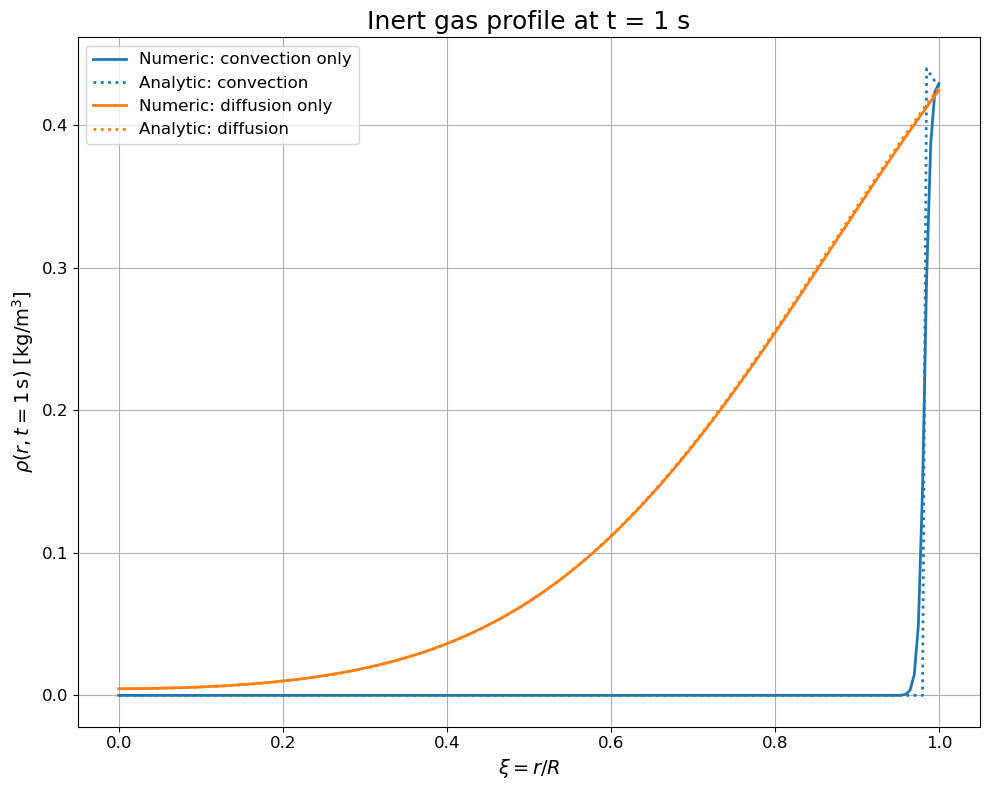

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

# --- Analytical functions ---
def theta_distribution_fourier(xi, tau, num_terms=50):
    """Dimensionless theta for diffusion in sphere."""
    theta = np.zeros_like(xi)
    for n in range(1, num_terms + 1):
        lambdan = n * np.pi
        term = (2 * (-1)**n / (n * np.pi * (xi + 1e-10))) * np.sin(n * np.pi * xi) * np.exp(-n**2 * np.pi**2 * tau)
        theta += term
    theta = 1 + theta
    return theta

def analytical_sphere_convection(r, t, R, u0, rho0_func, rho_inf=0.0):
    """Analytical solution for pure convection in sphere with inflow at r=R."""
    uprate = abs(u0)
    rho = np.empty_like(r, dtype=float)
    tau = (R - r)/uprate
    mask = t < tau
    r_adv = r[mask] + uprate * t
    rho[mask] = ((r_adv / (r[mask] + 1e-10))**2) * rho0_func(r_adv)
    rho[~mask] = (R/r[~mask])**2 * rho_inf
    return rho

# --- Configuration ---
Nr = 200
Nc = 7
dt = 0.001
t_end = 1.0     # run to t = 1.0 s
R = 5e-3
T = 800
R_univ = 8.314
P_atm  = 101325.0
MW_N2  = 28e-3

# inert gas settings
inert_idx = 6
rho_inf = P_atm * MW_N2 / (R_univ * T)

shape_pm = (Nr, Nc)

r_vals = np.linspace(0, R, Nr)
xi = r_vals / R

# Common BC
h_mass = 1.0
rho_bulk = np.zeros(Nc)
rho_bulk[inert_idx] = rho_inf

# Common initial conditions
c0 = np.zeros(shape_pm)
c0[:,0] = 1000.0  # Biomass
c0[:,4] =   90.0  # Moisture
c0[:,6] = 0.0     # Initial inert conc.

# --- Run convection only ---
D_vec_conv = np.zeros(Nc)
v_profile_conv = np.zeros(Nc)
for j in [1,2,5,6]:
    v_profile_conv[j] = -1e-4

model_conv = ParticleModel(
    shape=shape_pm,
    axis=0,
    L=R,
    v=v_profile_conv,
    D=D_vec_conv,
    c_0=c0,
    h_mass=h_mass,
    rho_bulk=rho_bulk,
    dt=dt,
    T=T
)

model_conv.test_inert = True
model_conv.rho_inf    = rho_inf
model_conv.inert_idx  = inert_idx

t_current = 0.0
while t_current < t_end:
    model_conv.step_dt()
    model_conv.solve()
    t_current += dt
rho_conv = (model_conv.c * model_conv.eps_p)[..., inert_idx].copy()

# --- Run diffusion only ---
D_inert = 1e-6
D_vec_diff = np.zeros(Nc)
for j in [1,2,5,6]:
    D_vec_diff[j] = D_inert
v_profile_diff = np.zeros(Nc)

model_diff = ParticleModel(
    shape=shape_pm,
    axis=0,
    L=R,
    v=v_profile_diff,
    D=D_vec_diff,
    c_0=c0,
    h_mass=h_mass,
    rho_bulk=rho_bulk,
    dt=dt,
    T=T
)

model_diff.test_inert = True
model_diff.rho_inf    = rho_inf
model_diff.inert_idx  = inert_idx

t_current = 0.0
while t_current < t_end:
    model_diff.step_dt()
    model_diff.solve()
    t_current += dt
rho_diff = (model_diff.c * model_diff.eps_p)[..., inert_idx].copy()

# --- Analytical convection ---
u_inert = abs(v_profile_conv[6])
rho_conv_ana = analytical_sphere_convection(
    r_vals,
    t_end,
    R,
    -u_inert,
    rho0_func = lambda r: 0.0,
    rho_inf = rho_inf
)

# --- Analytical diffusion ---
tau = D_inert * t_end / R**2
theta = theta_distribution_fourier(xi, tau)
rho_diff_ana = rho_inf * theta

# --- Error calculation function ---
def compute_error_metrics(numerical, analytical, label):
    abs_err = np.abs(numerical - analytical)
    l1 = np.mean(abs_err)
    l2 = np.sqrt(np.mean(abs_err**2))
    linf = np.max(abs_err)
    rmse = l2
    print(f"{label} Error Metrics:")
    print(f"  L1 norm   = {l1:.4e}")
    print(f"  L2 norm   = {l2:.4e}")
    print(f"  L∞ norm   = {linf:.4e}")
    print(f"  RMSE      = {rmse:.4e}\n")

# --- Compute and print errors ---
compute_error_metrics(rho_conv, rho_conv_ana, "Convection")
compute_error_metrics(rho_diff, rho_diff_ana, "Diffusion")


plt.figure(figsize=(10,8))

# Colors
color_conv  = 'tab:blue'
color_diff  = 'tab:orange'

# Numeric convection
plt.plot(xi, rho_conv,
         linestyle='-', color=color_conv, linewidth=2,
         label="Numeric: convection only")

# Analytic convection
plt.plot(xi, rho_conv_ana,
         linestyle=':', color=color_conv, linewidth=2,
         label="Analytic: convection")

# Numeric diffusion
plt.plot(xi, rho_diff,
         linestyle='-', color=color_diff, linewidth=2,
         label="Numeric: diffusion only")

# Analytic diffusion
plt.plot(xi[2:], rho_diff_ana[2:],
         linestyle=':', color=color_diff, linewidth=2,
         label="Analytic: diffusion")

plt.xlabel(r"$\xi = r/R$", fontsize=14)
plt.ylabel(r"$\rho(r,t=1\,\mathrm{s})$ [kg/m$^3$]", fontsize=14)
plt.title("Inert gas profile at t = 1 s", fontsize=18)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.savefig("DvsC_verification.png", dpi=300, bbox_inches='tight')
plt.show()


